
# 1. Introduction

In this study we'll try to predict the **Weight** of a fish using the informations contained in the **Fish Dataset**.
In the first part, we're going to focus on understanding the data and all of his variables, using statistical analysis and visualization techniques. After that, we're going to use **Multiple Linear Regression** and a series of tests and plots to build different models, and decide which is the optimal choice to complete our task.


# 2. Libraries

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


These are the libraries we need:

- **seaborn** and **matplotlib**: For various visualization functions. 
- **pandas**: For data cleaning and manipulation.
- **numpy**: For some useful math functions
- **statsmodel** and **sklearn**: For modelling,Tests,Predictions, and Train/Test splitting. 
    We're going to use this libraries also for the function *het_breuschpagan()*, that allows us to perform a **Breusch & Pagan Test**. This test is used to check if the residuals of our linear       model are **Heteroskedastical** or **Homoskedastical**.
    
    If you don't know what i'm talking about, I raccomend reading more about heteroskedasticity and **B&P Test** at this [link](https://rstudio-pubs-static.s3.amazonaws.com/187387_3ca34c107405427db0e0f01252b3fbdb.html).

# 3. Importing Data and first Analysis

Let's start by importing the dataset.

In [2]:
fish = pd.read_csv("../input/fish-market/Fish.csv")


We can take a first look at the our data using the *head()* and *info()* methods.


In [3]:
fish.head(5)

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [4]:
fish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
Species    159 non-null object
Weight     159 non-null float64
Length1    159 non-null float64
Length2    159 non-null float64
Length3    159 non-null float64
Height     159 non-null float64
Width      159 non-null float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


As you can see, all the variables are well specified.
**Species** is the only factor variable, while the other six are continuous.
Later, **Weight** is going to be our dependent variable, and we are going to predict it's value using the other features as **indipendent variables**.

For a better understanding of the meaning of the variables, it's preferable to change their names.

In [5]:
fish.columns = ['Species', 'Weight', 'LengthV', 'LengthD', 'LengthC', 'Height','Width']

Let's use the *describe()* method to see how our dataset is structured and check if there are any obvious **outliers** or **missing values**

In [6]:
fish.describe().round(1)

,Weight,LengthV,LengthD,LengthC,Height,Width
count,159.0,159.0,159.0,159.0,159.0,159.0
mean,398.3,26.2,28.4,31.2,9.0,4.4
std,358.0,10.0,10.7,11.6,4.3,1.7
min,0.0,7.5,8.4,8.8,1.7,1.0
25%,120.0,19.0,21.0,23.2,5.9,3.4
50%,273.0,25.2,27.3,29.4,7.8,4.2
75%,650.0,32.7,35.5,39.7,12.4,5.6
max,1650.0,59.0,63.4,68.0,19.0,8.1


The dataset doesn't have any missing value, and there are no negative values. Our data is already fairly clean!

There's only one observation that we need to fix:


In [7]:
fish.iloc[40,:]

Species     Roach
Weight          0
LengthV        19
LengthD      20.5
LengthC      22.8
Height     6.4752
Width      3.3516
Name: 40, dtype: object

The fish at row 40 weights **0 g**. So, to avoid errors when using the logarithmic transformation, it's better to drop this observation.

In [8]:
fish = fish.loc[fish["Weight"]>0,:]

# 4. Analysis and Visulization

Using the *describe()* and *info()* functions we collected a lot of interesting informations. But that's not enough!.
Before diving in the modelling and prediction phase, we need to deeply understand our data, through some really simple visualization and data analysis techniques.

Let's take a look at the distribution of our dependent variable, **Weight**, using an **distplot**

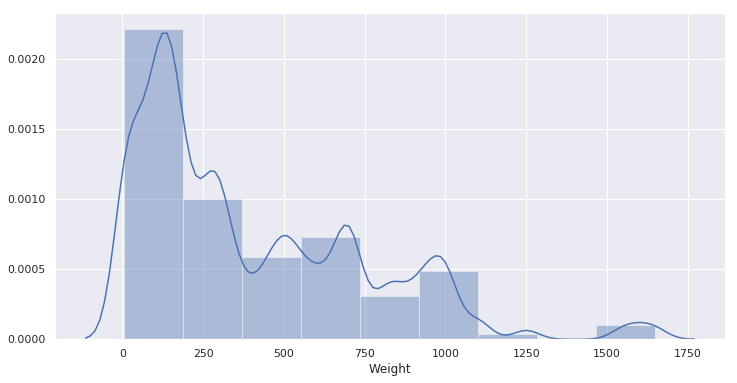

In [9]:
sns.set()
plt.figure(figsize=[12,6])

sns.distplot(fish["Weight"],kde_kws={"bw":40})
plt.show()

To rapidly visualize all of our continuous data, We can use the function *pairplot()*.

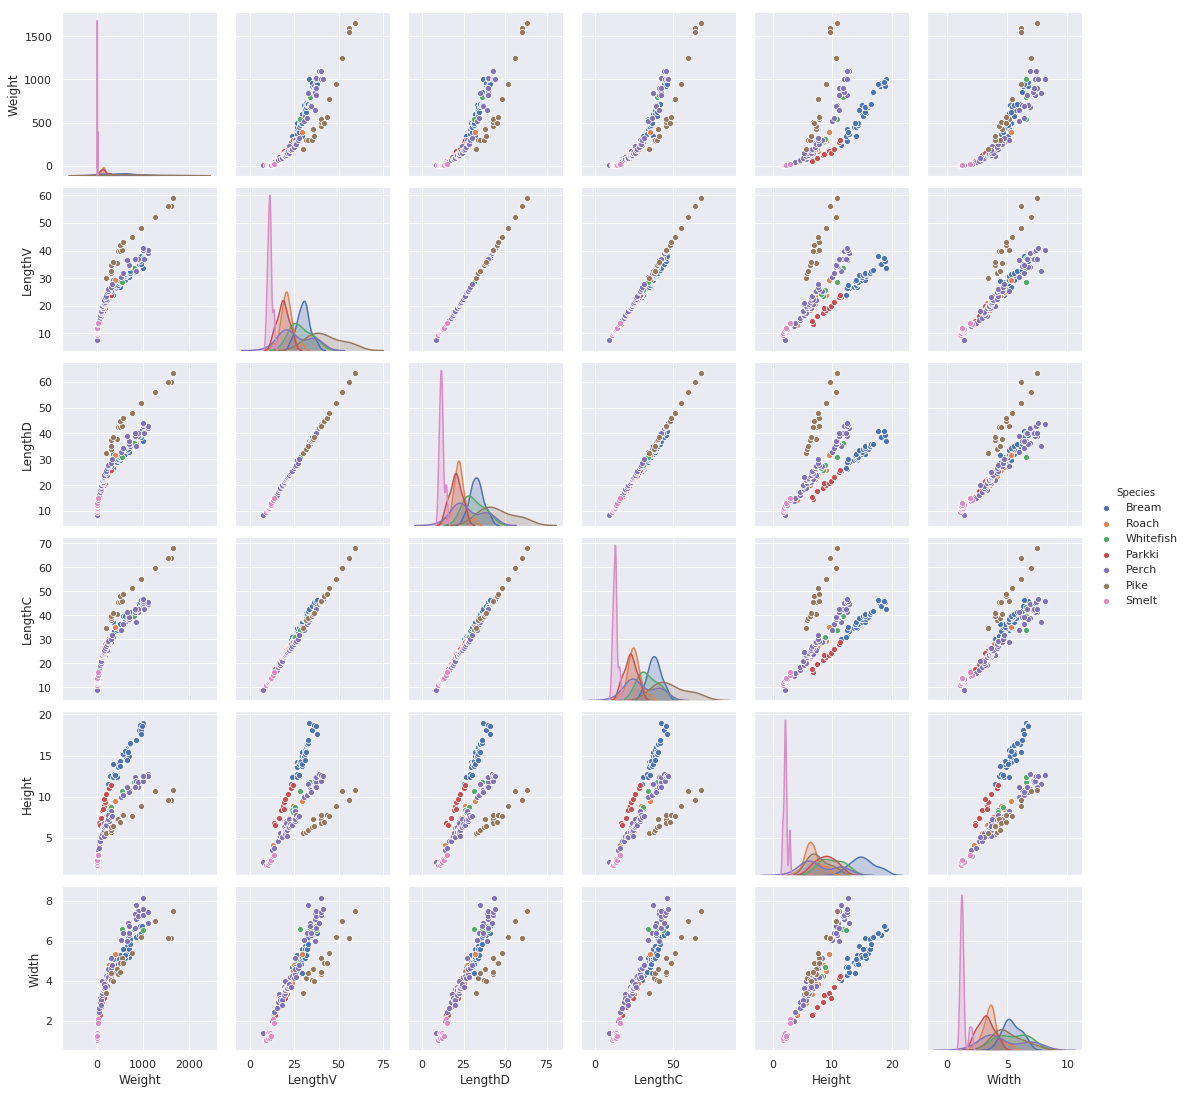

In [10]:
sns.pairplot(fish,hue="Species")
plt.show()

This **multivariate plot** gives us two notable informations that we need to deepen before modelling:

1. *The relationship between **Weight** and the other variables **isn't linear***
The following scatterplots analize more in-depth the distribution of **Weight** compared to **LengthV**, **Height** and **Width**.

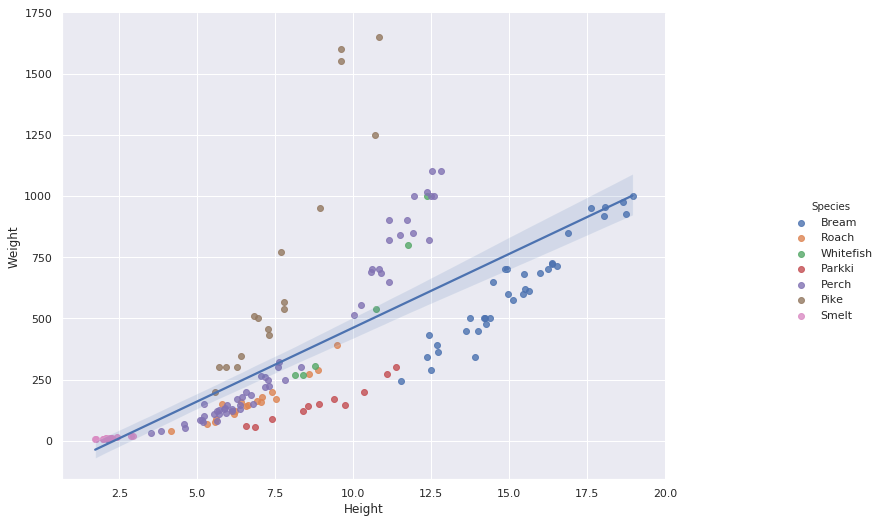

In [11]:
sns.lmplot(x="Height", y="Weight", hue="Species", data=fish, fit_reg=False)
sns.regplot(x="Height", y="Weight", data=fish, scatter=False)
plt.gcf().set_size_inches(14, 8)
plt.show()

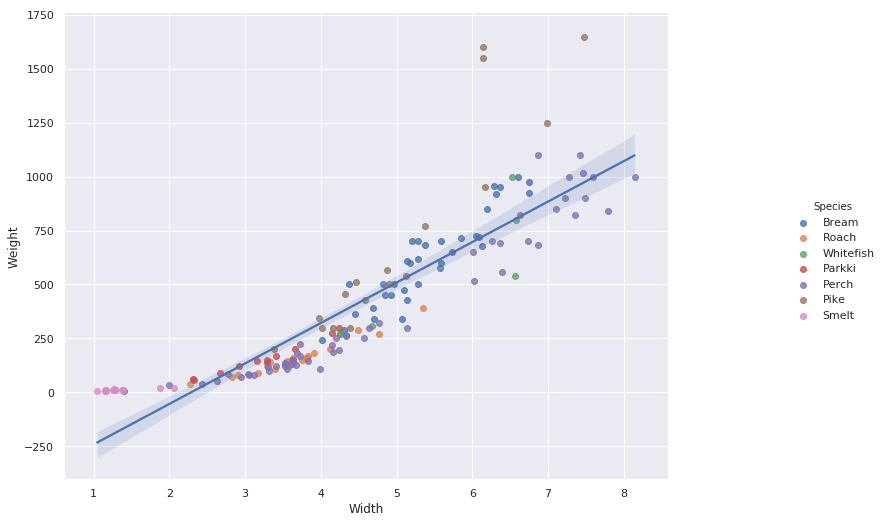

In [12]:
sns.lmplot(x="Width", y="Weight", hue="Species", data=fish, fit_reg=False)
sns.regplot(x="Width", y="Weight", data=fish, scatter=False)
plt.gcf().set_size_inches(14, 8)
plt.show()

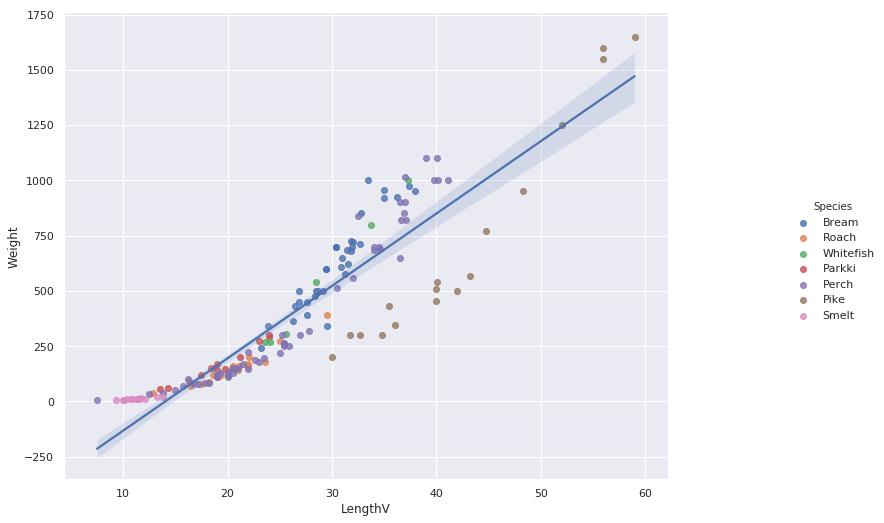

In [13]:
sns.lmplot(x="LengthV", y="Weight", hue="Species", data=fish, fit_reg=False)
sns.regplot(x="LengthV", y="Weight", data=fish, scatter=False)
plt.gcf().set_size_inches(14, 8)
plt.show()

**These relationships aren't linear**. So, fitting a straight line through the data doesn't give us the best results. A linear model doesn't capture the **non-linearity** of the relationships between our dependend variable and the other features that we are going to use in our regression models. 

We have two ways to fix this issue:

 - Find a more complex model that can explain what a simple straight line cannot;
 - Transform our data to linearize the relationship between **Weight** and the other variables;
 
The second option is really simple and works well for our necessities.
By applying a logarithmic transformation to **Weight**,**LenghtV**,**Height** and **Width** the problem is solved!


In [14]:
fish["Weightlog"] = np.log(fish["Weight"])
fish["Widthlog"] = np.log(fish["Width"])
fish["Heightlog"] = np.log(fish["Height"])
fish["LengthVlog"] = np.log(fish["LengthV"])

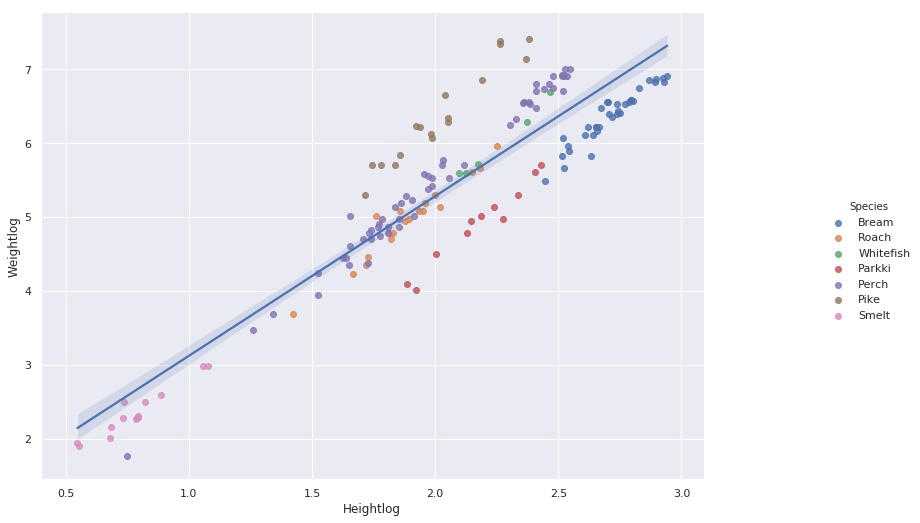

In [15]:
sns.lmplot(x="Heightlog", y="Weightlog", hue="Species", data=fish, fit_reg=False)
sns.regplot(x="Heightlog", y="Weightlog", data=fish, scatter=False)
plt.gcf().set_size_inches(14, 8)
plt.show()

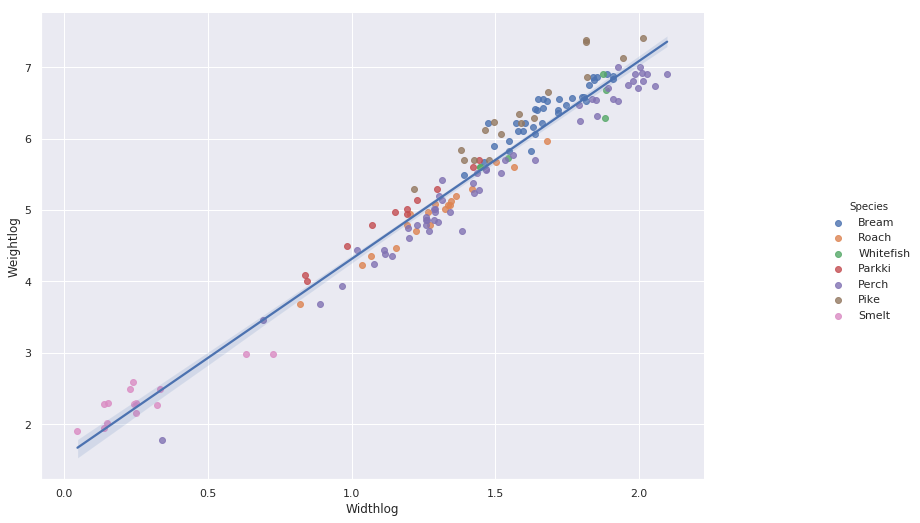

In [16]:
sns.lmplot(x="Widthlog", y="Weightlog", hue="Species", data=fish, fit_reg=False)
sns.regplot(x="Widthlog", y="Weightlog", data=fish, scatter=False)
plt.gcf().set_size_inches(14, 8)
plt.show()

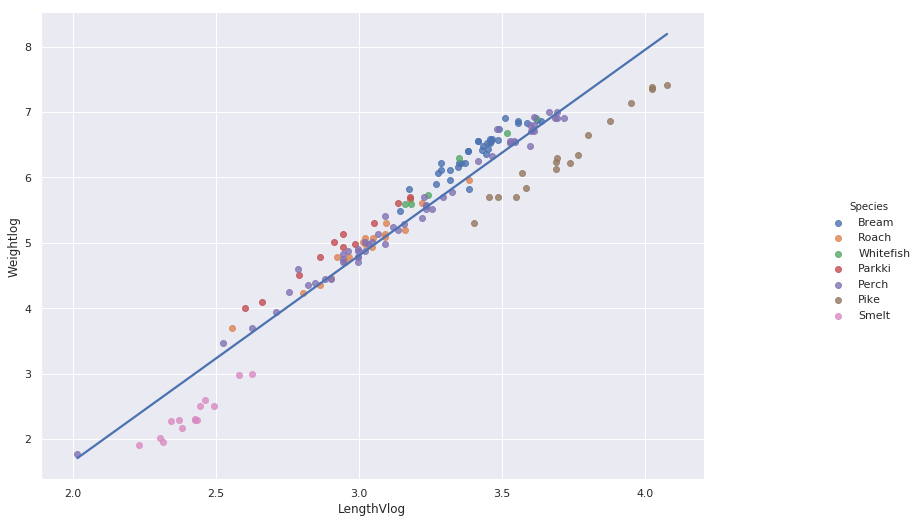

In [17]:
sns.lmplot(x="LengthVlog", y="Weightlog", hue="Species", data=fish, fit_reg=False)
sns.regplot(x="LengthVlog", y="Weightlog", data=fish, scatter=False,ci=None)
plt.gcf().set_size_inches(14, 8)
plt.show()


A straight line now perfectly fits our data, and the differences between the various **Species** are less markable.


2. The correlation between **LengthV**, **LengthD** and **LengthC** is almost equal to **1**

With the *cor()* function, we obtain a [variance-covariance matrix](https://datascienceplus.com/understanding-the-covariance-matrix/) for our **indipendent variables**.


In [18]:
fish_x = fish.loc[:,["LengthV","LengthD","LengthC","Height","Width"]]

fish_x.corr()

,LengthV,LengthD,LengthC,Height,Width
LengthV,1.000000,0.999516,0.992004,0.624409,0.866684
LengthD,0.999516,1.000000,0.994083,0.639503,0.873201
LengthC,0.992004,0.994083,1.000000,0.702655,0.878189
Height,0.624409,0.639503,0.702655,1.000000,0.792401
Width,0.866684,0.873201,0.878189,0.792401,1.000000


The correlation values between **LengthV**, **LengthD** and **LengthC** are **0.9995**,**0.9920** and **0.9941**. 

Having two or more variables which are almost a **linear combination** of each other can cause some serious issues to our regression model. This problem is called **Multicollinearity**(learn more about collinearity [here](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)). The fact that these three variables are Multicollinear means that we have redundant informations.

We will discuss more deeply about this problem later.

We have plotted and analyzed our data enough. Now let's start modelling!


# 5. Multiple Linear Regression

The first model that we're going to use is **Multiple Linear Regression**. Our dependent variable is **Weight**, and our indipendent variables are **LengthV**,**LengthD**,**LengthC**,**Height** and **Width**. I didn't use the **Species** coloumn to not over-complicate the model. **Species** is a factor variable with **7 different levels**. Using this variable means creating 7 dummy variables, and have 7 different straight lines,each one with a unique intecept. 
Too complicated! **KISS** . 

The following script creates the multiple linear model that we need:

In [19]:
y = fish["Weight"]
x = fish.loc[:,["LengthV","LengthD","LengthC","Height","Width"]]

x = sm.add_constant(x)
fish_reg = sm.OLS(y,x).fit()
fish_reg.summary()  

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     235.1
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.27e-69
Time:                        18:59:18   Log-Likelihood:                -981.49
No. Observations:                 158   AIC:                             1975.
Df Residuals:                     152   BIC:                             1993.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -496.8023     29.616    -16.775      0.000    -555.315    -438.290
LengthV       63.9695     40.169      1.592      0.113     -15.393     143.332
LengthD       -9.1085     41.749     -0.218      0.828     -91.592      73.375
LengthC      -28.1189     17.343     -1.621      0.107     -62.383       6.145
Height        27.9262      8.721      3.202      0.002      10.696      45.157
Width         23.4123     20.355      1.150      0.252     -16.804      63.628
==============================================================================
Omnibus:                       21.459   Durbin-Watson:                   0.414
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.402
Skew:                           0.801   Prob(JB):                     6.80e-07
Kurtosis:                       4.323   Cond. No.                         315.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The **p-value** of the variables **LengthV**,**LengthC** and **LengthD** is quite high, suggesting us that these variables are not significant. These p-values are caused by the high correlation between the three types of Length. We can solve **collinearity** in three ways:

- Increasing the number of observation (**n**)
- Introducing new variables
- Removing the collinear variables

The third approch is the best in our case. We can't add new observations, and by removing redundant variables we don't lose too much informations. So, we can remove **LengthD** and **LengthC**, and just consider **LengthV**


In [20]:
y = fish["Weight"]
x = fish.loc[:,["LengthV","Height","Width"]]

x = sm.add_constant(x)
fish_reg_red = sm.OLS(y,x).fit()
fish_reg_red.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     386.7
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.90e-71
Time:                        18:59:18   Log-Likelihood:                -983.32
No. Observations:                 158   AIC:                             1975.
Df Residuals:                     154   BIC:                             1987.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -511.4706     28.593    -17.888      0.000    -567.955    -454.986
LengthV       22.6047      2.019     11.198      0.000      18.617      26.593
Height        13.5898      3.848      3.532      0.001       5.988      21.191
Width         44.2661     15.321      2.889      0.004      13.999      74.533
==============================================================================
Omnibus:                       19.258   Durbin-Watson:                   0.388
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.095
Skew:                           0.795   Prob(JB):                     9.66e-06
Kurtosis:                       3.991   Cond. No.                         87.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Using only **LengthV**,**Height** and **Width**, all the p-values decreased, and the variance of the parameter associated with **LengthV** is now acceptable. 

Obviusly the **R2** decreased, but that's not a problem. 
(*Don't use the R2 statistic to compare two model with different number of indipendent variable!*)

To understand which model performs better on our data, we use three useful tools:  **F-test**,**AIC** and **BIC**

In [21]:
print( "P-Value of the F-Test:\t\t\t",round(fish_reg.compare_f_test(fish_reg_red)[1],4),"\n")


print("AIC for the non-Restricted model:\t",round(fish_reg.aic,4))
print("AIC for the non-Restricted model:\t",round(fish_reg_red.aic,4),"\n")

print("BIC for the non-Restricted model:\t",round(fish_reg.bic,4))
print("BIC for the non-Restricted model:\t",round(fish_reg_red.bic,4))

P-Value of the F-Test:			 0.1722 

AIC for the non-Restricted model:	 1974.9739
AIC for the non-Restricted model:	 1974.6309 

BIC for the non-Restricted model:	 1993.3495
BIC for the non-Restricted model:	 1986.8813



The *compare_f_test()* method performs for us a F-test. The resultant **p-value** is higher than **0.10**, so we don't refuse the null Hypotesis. Also, the **AIC** and **BIC** have smaller values with the *fish_reg_red* model. In simple terms, using the two "extra" variables **LengthC** and **LengthD** didn't increase enough our knowledge about the dependent variable (**Weight**), and so it's better to use a simpler model (*fish_reg_red*). 

Let's take a look at the distribution of residuals:

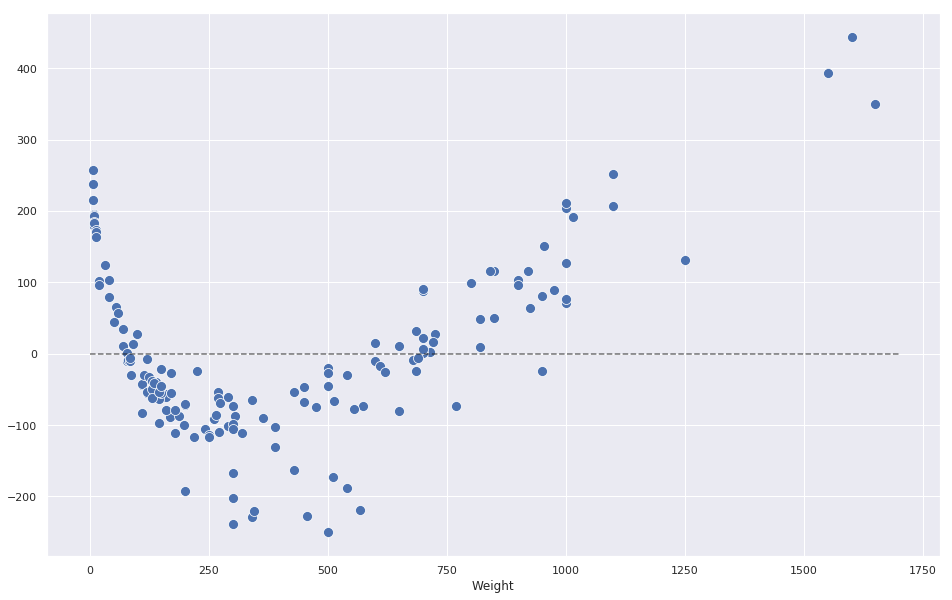

In [22]:
plt.figure(figsize=(16,10))
plt.hlines(0,xmin=0,xmax=1700,linestyle="dashed",alpha=0.6)
sns.scatterplot(y,fish_reg_red.resid,s=100)

plt.show()


That's not how residuals should look like! As you can see, the residuals follow a **visible pattern**. 
If a model really explains the relationship between the dependent variable and the indipendent variables this should not happen!

The model *fish_reg_red* has an high **R2**,and all of the parameters are significant, but it certainly fails in capturing the real relationship between the **Y** and the **Xs**.

Luckly, we already now that applying a loghritimic transformation to our data the relationship becomes linear.

So let's transform our data and fit a new model


In [23]:
y_log = fish["Weightlog"]
x_log = fish.loc[:,["LengthVlog","Heightlog","Widthlog"]]

x_log = sm.add_constant(x_log)
fish_reg_ll = sm.OLS(y_log,x_log).fit()
fish_reg_ll.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Weightlog   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     9349.
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          5.80e-174
Time:                        18:59:19   Log-Likelihood:                 143.31
No. Observations:                 158   AIC:                            -278.6
Df Residuals:                     154   BIC:                            -266.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7730      0.115    -15.438      0.000      -2.000      -1.546
LengthVlog     1.4295      0.052     27.722      0.000       1.328       1.531
Heightlog      0.6293      0.033     19.111      0.000       0.564       0.694
Widthlog       0.9487      0.062     15.339      0.000       0.827       1.071
==============================================================================
Omnibus:                       18.425   Durbin-Watson:                   1.619
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.146
Skew:                          -0.463   Prob(JB):                     7.05e-10
Kurtosis:                       5.355   Cond. No.                         72.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This type of model is called **Log-Log linear regression** (learn more about it [here](https://www.dummies.com/education/economics/econometrics/econometrics-and-the-log-log-model/))

All the variables are very statistically significant and the **R2** is really high!. But we can't use the **R2**, or tools like the **AIC** and the **BIC** to compare the **Log-Log model** with the *fish_red_reg* model because the dependent variable is not the same (**y** is not equal to **log(y)**)

But since our final objective is prediction, we can try to predict the Weight with both models and then check wich model does it better.

Let's check if the logharitmic tranformation fixed our problems with the distribution of residuals:

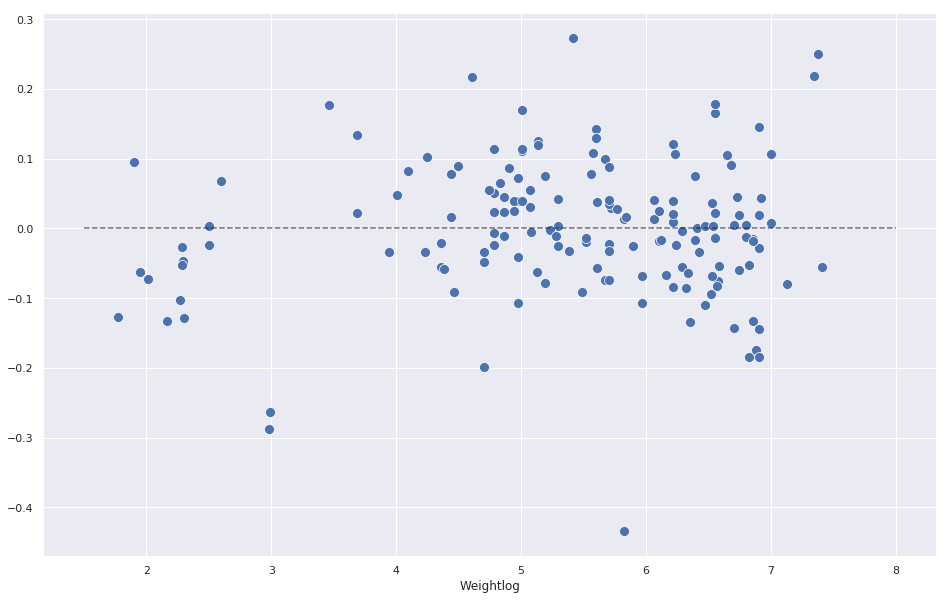

In [24]:
plt.figure(figsize=(16,10))
plt.hlines(0,xmin=1.5,xmax=8,linestyle="dashed",alpha=0.6)
sns.scatterplot(y_log,fish_reg_ll.resid,s=100)

plt.show()

Great! 
Now the residuals don't follow a scheme, and so we are sure that the **Log-Log** model captures the real relationship between **Weight** and **LengthV**,**Height** and **Width**.

Just to be sure, we can use a **Breusch & Pagan Test** to check if the residuals are **heteroskedastical**


In [25]:
print("P-Value of Breusch & Pagan Test: ",round(het_breuschpagan(fish_reg_ll.resid,x_log)[1],4))

P-Value of Breusch & Pagan Test:  0.9272



The **Null Hypothesis** is not rejected (it means that the residuals are **homoskedastical**), so we don't need to fix heteroskedasticity issues.


# 6. Prediction

Let's now use all the things that we have learned to predict the **Weight** of a fish. We're going to make predictions with two models, *fish_reg_red* and *fish_reg_ll*, and check which model does the better job.

With the following script, we split our data in **Train** set and **Test** set...

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=5)

X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(x_log, y_log, test_size=0.3,random_state=5)

And fit our **two models** only using the observations that are in the **training set**.


In [27]:
X_train = sm.add_constant(X_train)
fish_reg_red = sm.OLS(y_train,X_train).fit()

X_log_train = sm.add_constant(X_log_train)
fish_reg_ll = sm.OLS(y_log_train,X_log_train).fit()


Using our two fitted multiple linear regression model, we can finally make predictions on the observations that are in the **test set**.



In [28]:
pred_lin = fish_reg_red.predict(X_test)
print("R2 of the Non-Transformed Linear Model:",round(r2_score(y_test,pred_lin),4))

pred_ll = np.exp(fish_reg_ll.predict(X_log_test))
print("R2 of the LogLog Linear Model:",round(r2_score(y_test,pred_ll),4))

R2 of the Non-Transformed Linear Model: 0.8967
R2 of the LogLog Linear Model: 0.9917


The **R2** of the prediction of the **Log-Log multiple linear regression** is much higher then the one obtained with the **non-trasformed multiple regression model**. 

The **Log-Log model** is better at predicting than the *fish_reg_red* model!

Let's use a scatterplot to visualize the real values of **Weight**, and the predictions made by our two different model

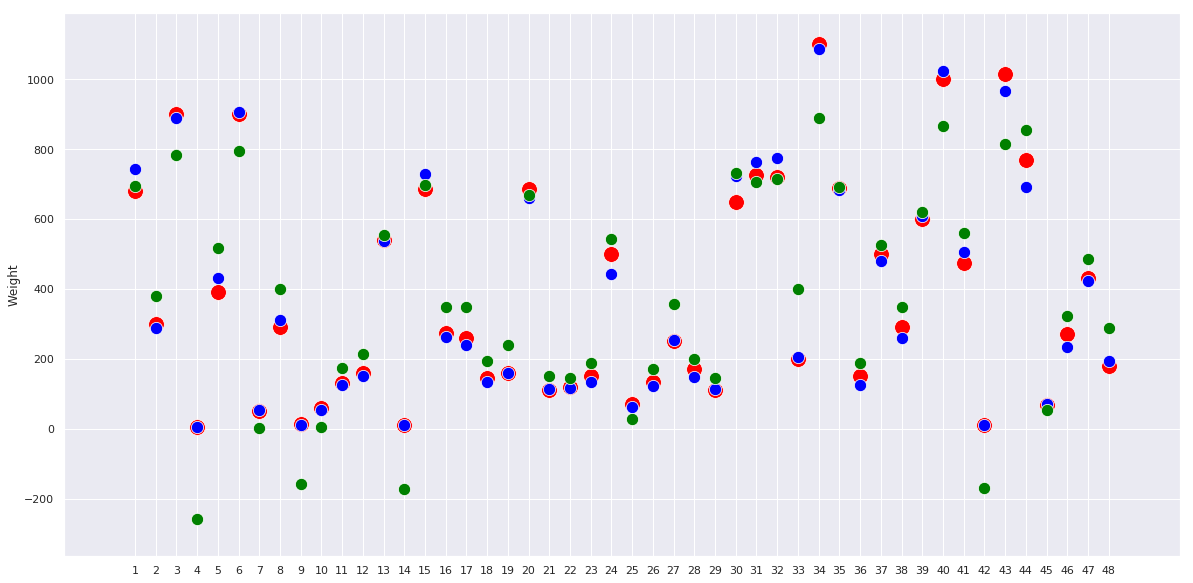

In [29]:

unit =np.r_[1:49]


fig, ax = plt.subplots()
sns.scatterplot(unit,y_test,color="red",s=250)
sns.scatterplot(unit,pred_ll,color="blue",s=150)
sns.scatterplot(unit,pred_lin,color="green",s=150)
ax.set_xticks(range(1,49))
plt.gcf().set_size_inches(20, 10)
plt.show()


The predictions made with the **Log-Log model** (blue dots) are clearly closer to the **real values** (red dots) then the predictions made with the **non-transformed linear model** (green dots).

It's also important to underline an useful propriety of the Log-Log model : **all the predictions made by this model are Positive**. 
Why? Because we used the exponential function to bring the fitted values back to the same unit of measurement of the real values. In our case this constraint is a great advantage, because obviously the weight of a fish cannot be negative.

On the other side, a **non-transformed multiple linear model** can also assume negative fitted values, which is a big issue if we want only positive predictions.

In [30]:
pd.DataFrame({"Pred_Lin":round(pred_lin[pred_lin<0],2),"Pred_LogLog":round(pred_ll[pred_lin<0],2),"Real_Values":y_test[pred_lin<0]})

,Pred_Lin,Pred_LogLog,Real_Values
72,-257.98,6.66,5.9
155,-157.53,12.53,13.4
153,-172.37,10.33,9.8
151,-170.06,11.36,10.0


# 7. Conclusion

In this study we predicted the **Weight** of a fish using two multiple linear model. We can conlude that the **Log-Log linear model** is by far the best regression model to predict the **Weight**, but if you really want to keep it simple, using a **Non-transformed linear regression** is a good choice too.

If you have read this far, I sincerely want to thank you for your attention and patience. This is my first notebook here on Kaggle, so if you find any type of error, or you just want to some more info or even if you have a different type of solution that you want to discuss, I invite you to leave a comment or to send me an e-mail.

### If this notebook helped you in any way or you liked it, please upvote and/or leave a comment!